# Imports

In [205]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Parameters

In [206]:
N_EPOCHS = 500
BATCH_SIZE = 16
DATASET_SIZE = 120
TRAIN_DATA_SIZE = 96
LATENT_DIM = 128

# Data importing and pre-processing

In [207]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(DATASET_SIZE, 64, 64, 1)

x_real_train, x_real_test = train_test_split(df, test_size=0.2) #12 test values


normalize dataset data into range of sigmoid [0,1], and put into batches

In [208]:
x_real_train = x_real_train.astype('float32')
x_real_train /=255


training_data = tf.data.Dataset.from_tensor_slices(x_real_train).shuffle(TRAIN_DATA_SIZE).batch(BATCH_SIZE)

Visualise example from dataset

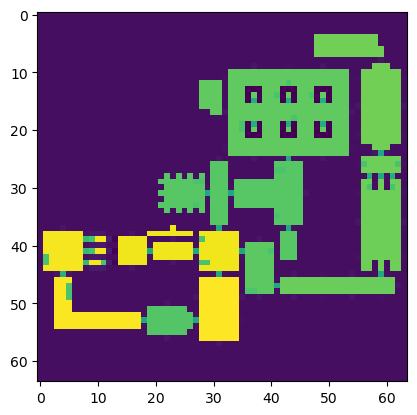

In [209]:
plt.imshow(x_real_train[0])

# Generator Model

Create points in latent space to be fed into generator

In [210]:
def generate_generator_input(no_of_maps):
    input = tf.random.normal(shape=(no_of_maps, LATENT_DIM))
    
    return input

In [211]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(LATENT_DIM*8*8, input_shape=(LATENT_DIM,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,LATENT_DIM)))


    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=5, padding="same"))
    model.add(Activation("sigmoid"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [212]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same", input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    

    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    '''
    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    '''
    model.add(Dense(100, activation='relu'))
    #model.add(Activation='relu')
    
    # output layer
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model
    

Create the models from the functions

In [213]:
gen_model = make_generator()

disc_model = make_discriminator()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 8192)              1056768   
                                                                 
 batch_normalization_69 (Ba  (None, 8192)              32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_12 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_48 (Conv2  (None, 16, 16, 128)       262144    
 DTranspose)                                                     
                                                                 
 batch_normalization_70 (Ba  (None, 16, 16, 128)     

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

## Loss and Optimizers

In [214]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, taken from: https://www.tensorflow.org/tutorials/generative/dcgan

In [215]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [216]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [217]:
gen_optimizer = Adam(learning_rate =0.0002, beta_1=0.5)
disc_optimizer = Adam(learning_rate =0.0002, beta_1=0.5)

Discriminator accuracy

In [218]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output[0] >=0:
        
        if fake_output[0] <0:
            accuracy = (real_output[0] + fake_output[0]) / (real_output[0] + fake_output[0])
        else:
            accuracy = real_output[0]/ (real_output[0] + fake_output[0])
    elif fake_output[0] <0:
        accuracy = fake_output[0] / (real_output[0] + fake_output[0])
    else:
        accuracy = 0/ (real_output[0] + fake_output[0])
    
    return accuracy

## Training

Training step

In [219]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input(BATCH_SIZE)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [220]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        disc_accuracies_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / TRAIN_DATA_SIZE
        avg_disc_loss = sum(disc_losses_for_epoch) / TRAIN_DATA_SIZE

        avg_disc_accuracy = sum(disc_accuracies_for_epoch) / TRAIN_DATA_SIZE

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        disc_accuracies.append(avg_disc_accuracy)

        print("Gen loss = " + str(avg_gen_loss))
        print("Disc loss = " + str(avg_disc_loss))

        print("Disc accuracy = " + str(avg_disc_accuracy))
# generate and show a map after 10 epochs

        if epoch % 10 == 0:
            noise_input = generate_generator_input(1)
            generated_map = gen_model(noise_input, training=False)
            generated_map = generated_map.numpy()
            generated_map.reshape(64,64)
            plt.imshow(generated_map)
    
    input_for_map_after_training = generate_generator_input(1)
    generated_map = gen_model(input_for_map_after_training, training=False)

    

    return gen_losses, disc_losses, generated_map, disc_accuracies


Train GAN

In [221]:

gen_losses, disc_losses, generated_map, disc_accuracies = train(training_data, N_EPOCHS)


epoch = 0
generated map shape(16, 64, 64, 1)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


generated map shape(16, 64, 64, 1)
Gen loss = tf.Tensor(0.034366567, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10011575, shape=(), dtype=float32)
Disc accuracy = 0.0


AttributeError: EagerTensor object has no attribute 'reshape'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      

Denormalize, save and display generated map output

In [ ]:
# denormalise generated map

generated_map *= 255

generated_map = generated_map.numpy()

generated_map = np.reshape(generated_map, (64,64))

generated_map = np.round(generated_map,0)
print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',', fmt='%i')

generated_map = generated_map.tolist()

print(generated_map)


plt.i

(64, 64)
[[31.0, 85.0, 79.0, 6.0, 23.0, 3.0, 19.0, 5.0, 3.0, 126.0, 15.0, 7.0, 27.0, 2.0, 15.0, 12.0, 1.0, 202.0, 19.0, 11.0, 24.0, 2.0, 15.0, 4.0, 28.0, 209.0, 31.0, 9.0, 124.0, 14.0, 16.0, 5.0, 7.0, 233.0, 12.0, 6.0, 24.0, 15.0, 2.0, 4.0, 15.0, 183.0, 5.0, 2.0, 5.0, 5.0, 7.0, 7.0, 17.0, 138.0, 18.0, 13.0, 6.0, 3.0, 19.0, 2.0, 8.0, 215.0, 28.0, 6.0, 20.0, 12.0, 17.0, 6.0], [5.0, 1.0, 3.0, 1.0, 13.0, 6.0, 2.0, 9.0, 8.0, 10.0, 5.0, 24.0, 12.0, 30.0, 16.0, 60.0, 69.0, 44.0, 100.0, 108.0, 47.0, 196.0, 22.0, 18.0, 23.0, 1.0, 3.0, 160.0, 3.0, 120.0, 6.0, 227.0, 48.0, 193.0, 24.0, 185.0, 58.0, 113.0, 165.0, 220.0, 12.0, 86.0, 50.0, 141.0, 18.0, 15.0, 10.0, 40.0, 24.0, 53.0, 12.0, 221.0, 25.0, 228.0, 3.0, 77.0, 72.0, 22.0, 12.0, 185.0, 125.0, 124.0, 8.0, 15.0], [1.0, 1.0, 0.0, 70.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 8.0, 4.0, 1.0, 1.0, 17.0, 0.0, 4.0, 16.0, 40.0, 14.0, 2.0, 2.0, 30.0, 1.0, 1.0, 3.0, 8.0, 10.0, 0.0, 2.0, 16.0, 3.0, 135.0, 43.0, 164.0, 44.0, 21.0, 4.0, 10.0, 20.0, 15.0, 12.0, 

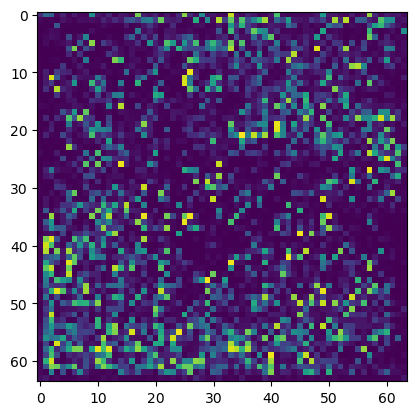

In [ ]:
plt.imshow(generated_map)

# Graphs:

Losses

Text(0.5, 0, 'Epoch')

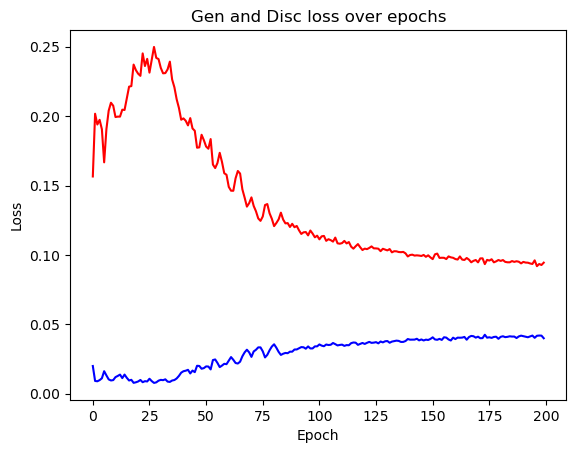

In [ ]:
epoch_list = [i for i in range(0,N_EPOCHS)]


plt.plot(epoch_list, disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Discriminator Accuracy

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1400,) + inhomogeneous part.

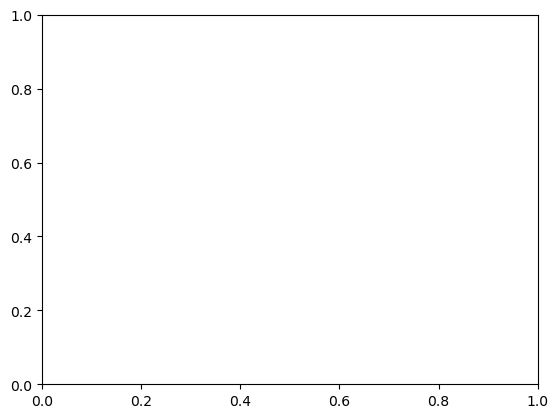

In [ ]:
plt.plot(epoch_list, disc_accuracies,  'r-')

plt.title('Disc accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')